In [1]:
import numpy as np
import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt



In [2]:
def Gauss(x,mu,sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))*1/np.sqrt(2*np.pi * sigma**2)

def func(x):
    return Gauss(x,0.2,0.01)
    #return np.cos(4*(x-0.2))**2
    #return np.exp(-x)

#vectorize func for convinience
#use func to calculate autocorrelation and the mean/variance of func. In practice, one might have a physical quantity to be estimated.
VF=np.vectorize(func)

In [3]:
def Metropolis(Target,xin,N=10000,eps=0.01,burn_in=0,thinning=10,_fixed_interval=True):
    '''
    burn_in (integer): do not store the first 'burn_in' accepted steps (the first few steps could be in a region with low probability).
    thinning (integer): store 1 every 'thinning' accepted steps (makes the sample more independent).
    _fixed_interval (boolean): if True keps x in [0,1].
    '''
    accepted=[]

    _n_b=0
    _n_t=0

    x=xin
    func_x=Target(x)

    for i in np.arange(N):
        if _fixed_interval:
            while True:

                #can=np.random.normal(x,eps)# Gaussian candidate position
                can=(np.random.rand()*2-1)*eps+x# Uniform candidate position
                if can<1 and can>0:#check if x stays inside [0,1] (for simplicity...)
                    break
        else:
            can=np.random.normal(x,eps)   #candidate position
        func_can=Target(can)


        if func_x<1e-50:
            a=1
        else:    
            a = min([1.,func_can/func_x]) #acceptance probability for symmetric prior
        u = np.random.rand()

        if u < a :
            x = can
            _n_b+=1
            _n_t+=1
            if _n_b>=burn_in and _n_t>thinning:

                _n_t=0
                accepted.append(x)#accept sample


        func_x=Target(can)
    return np.array(accepted)

In [34]:
#run Metropolis
accepted=Metropolis(Target=func,xin=0,N=50000,eps=0.0025,burn_in=2000,thinning=50)
_len=len(accepted)
print _len

895


<IPython.core.display.Javascript object>


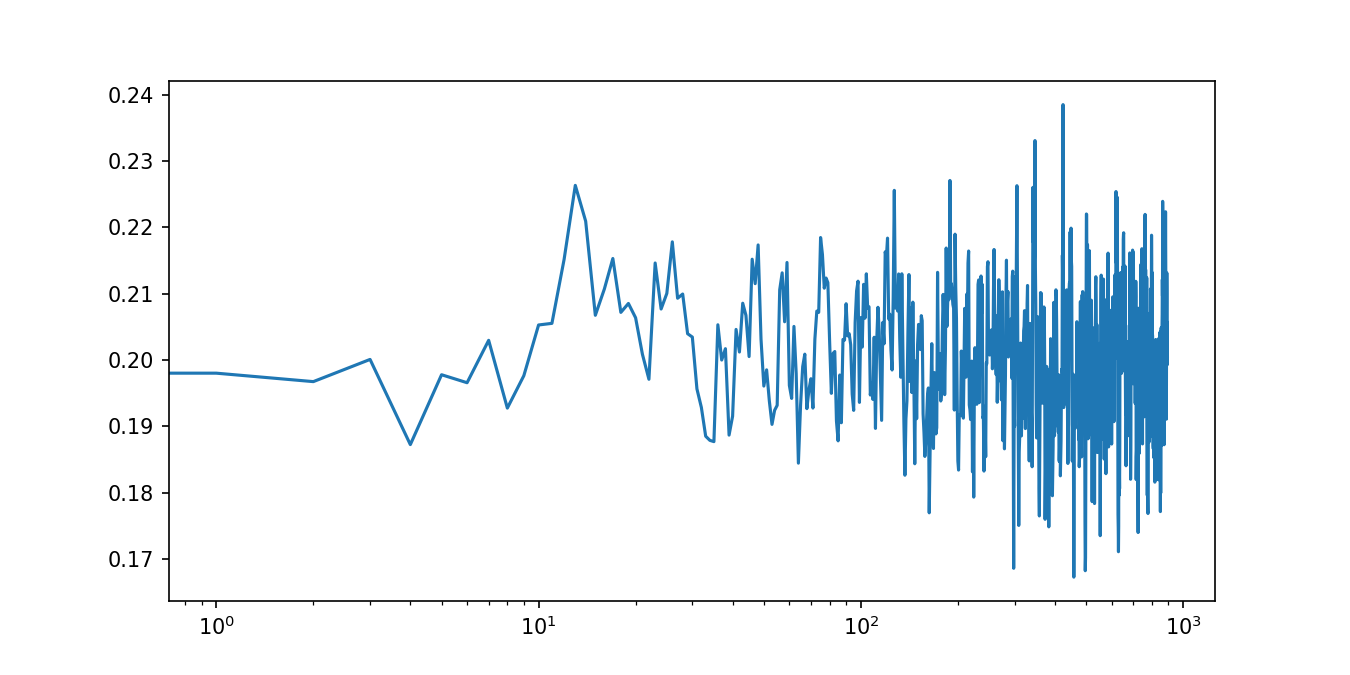

In [35]:
#===========================================================================================================================================#
#traceplot of x (use it to determine burn_in).
_trace=True #set True to see the plot
if _trace:
    plt.figure(figsize=(9,4.5))
    plt.plot(np.arange(_len), accepted )
    
    plt.xscale('log')
    plt.show()
#===========================================================================================================================================#

C:\Users\dkara\Anaconda2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


-0.015765678573048912 0.02975845207776446


<IPython.core.display.Javascript object>


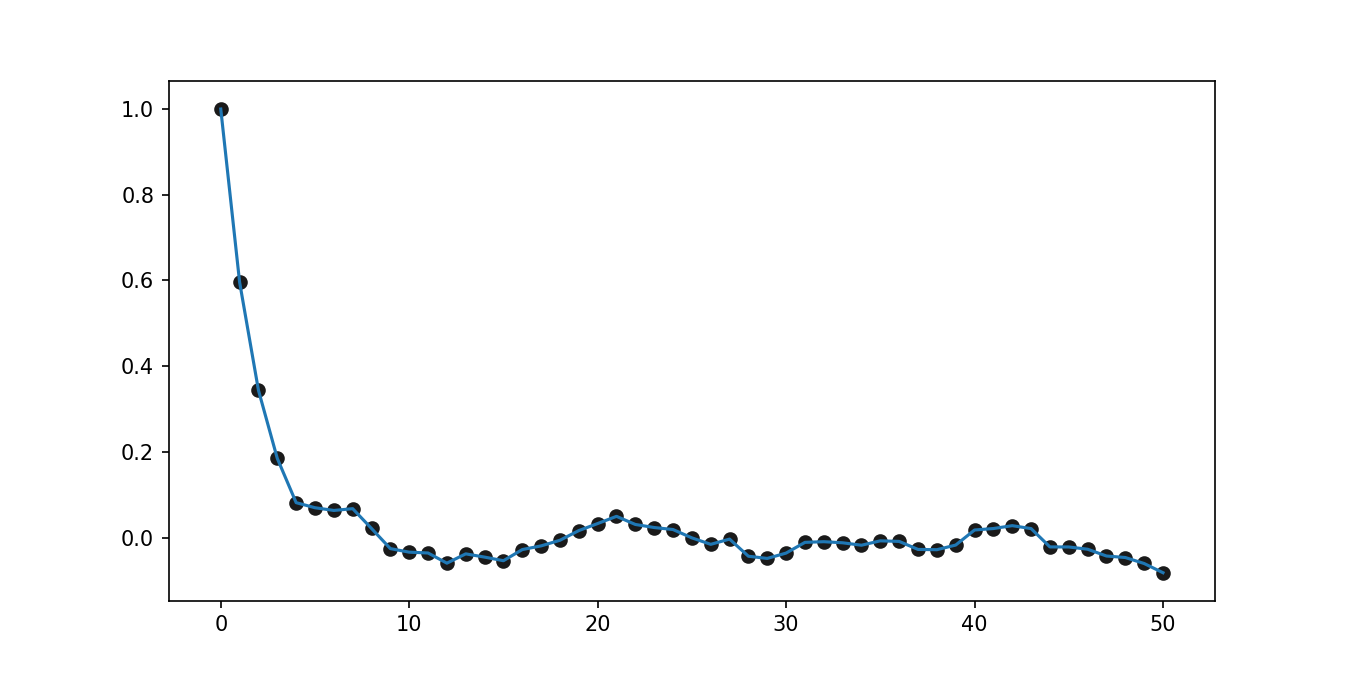

In [36]:
#===========================================================================================================================================#
#plot the autocorrelation function (ACF) (use it to determine the thinning)
_ACF=True #set True to see the plot
if _ACF:

    def ACF(X,N,n=5):#returns the first N ACFs
        _mu=np.mean(X)
        _len=len(X)

        if N>_len:
            N=_len

        _g=lambda k:np.sum([(X[i]-_mu)*(X[i+k]-_mu) for i in np.arange(1,_len-k)])
        acf=[_g(k) for k in np.arange(0,N,n)]
        return np.array(acf)/_g(0)

    N=51

    if N>_len:
        N=_len
    n=1

    acf=ACF(accepted,N,n)
    #acf=ACF(VF(accepted),N,n)
    print np.mean(acf[10:]),np.sqrt(np.var(acf[10:],ddof=1))
    plt.figure(figsize=(9,4.5))
    plt.plot(np.arange(0,N,n),acf)
    plt.scatter(np.arange(0,N,n),acf,color=(0.1,0.1,0.1,1))
    plt.show()
#===========================================================================================================================================#

<IPython.core.display.Javascript object>


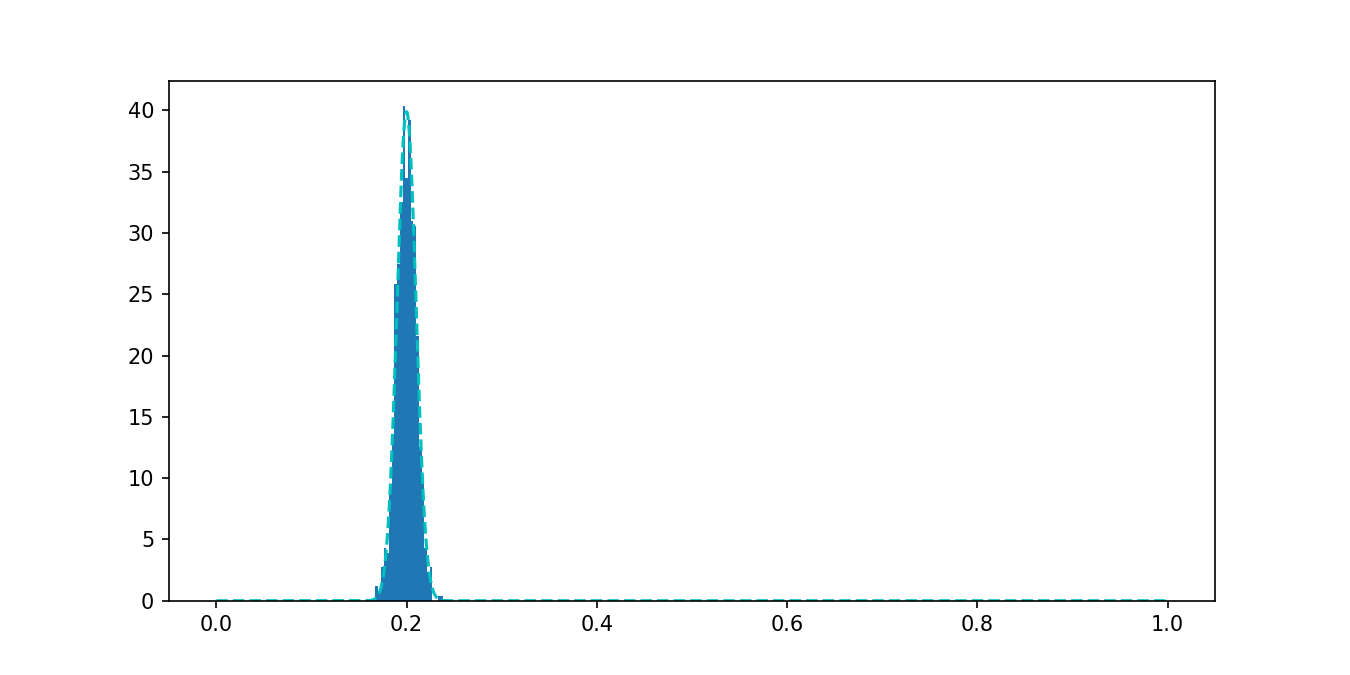

In [37]:
#normalized Histogram of sample vs normalized target distribution
plots=True
if plots:
    import scipy.integrate as integrate

    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(9, 4.5))
    x=np.array([i for i in np.arange(0,1,0.0001) ])
    y=VF(x)
    norm=integrate.quad(func,0,1)[0]#normalization of func
    y=y/norm
    ax.plot(x,y,'c--')
    ax.hist(accepted,bins='auto',density=True)#it would only work for normalized func...

    plt.show()

Points per bin= 1 No. bins= 788 Total points= 788
Points per bin= 2 No. bins= 394 Total points= 788
Points per bin= 4 No. bins= 197 Total points= 788
Points per bin= 8 No. bins= 98 Total points= 784
Points per bin= 16 No. bins= 49 Total points= 784
Points per bin= 32 No. bins= 24 Total points= 768
Points per bin= 64 No. bins= 12 Total points= 768
Points per bin= 128 No. bins= 6 Total points= 768
Points per bin= 256 No. bins= 3 Total points= 768


<IPython.core.display.Javascript object>


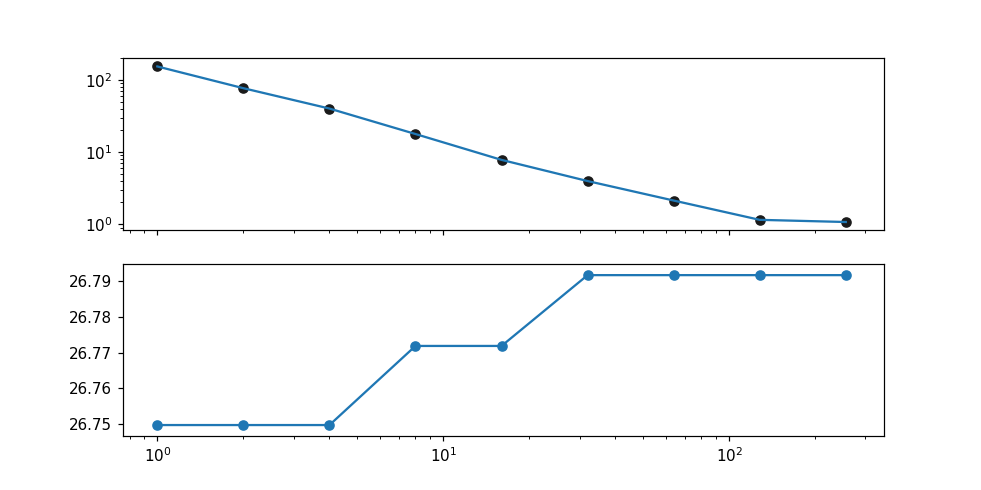

In [27]:
#Plot sigma and mean of func (or x if you uncomment it) for various binning.
#===========================================================================================================================================#
#break the accepted in bins of NB length and plot the variance for a various number of bins.
_NOB=True #set True to see the plots
if _NOB:

    means=[]
    vars=[]
    NBs=[]

    _len=len(accepted)
    for k in np.arange(0,50):
        NB=int(2**k)#batch length
        bins=int(_len/float(NB))
        if bins<2:
            break

        print r'Points per bin=', NB ,r'No. bins=', bins, r'Total points=',NB*bins

        batch_means= [ np.mean([ func(accepted[batch*NB+i]) for i in np.arange(NB) ])  for batch in np.arange(bins)]
        #batch_means= [ np.mean([ accepted[batch*NB+i] for i in np.arange(NB) ])  for batch in np.arange(bins)]
        means.append(np.mean(batch_means))
        vars.append( np.var(batch_means,ddof=1))



        #NBs.append(bins)
        NBs.append(NB)

    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(9, 4.5),sharex=True)

    ax[0].plot( NBs,vars )
    ax[0].scatter( NBs,vars,color=(0.1,0.1,0.1,1) )
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    ax[1].plot( NBs,means )
    ax[1].scatter( NBs,means )
    ax[1].set_xscale('log')

    plt.show()
#===========================================================================================================================================#